In [1]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.metrics import silhouette_score, rand_score
import matplotlib.pyplot as plt
import seaborn as sns
from feature_engineering import process_categorical_columns

In [2]:
df = pd.read_csv('StudentPerformanceFactorsCleaned.csv')
df = process_categorical_columns(df)

In [3]:
df.head()

,Hours_Studied,Attendance,Parental_Involvement,Access_to_Resources,Extracurricular_Activities_Yes,Sleep_Hours,Previous_Scores,Motivation_Level,Internet_Access_Yes,Tutoring_Sessions,Family_Income,Teacher_Quality,School_Type_Public,Peer_Influence,Physical_Activity,Learning_Disabilities_Yes,Parental_Education_Level,Gender_Male,Exam_Score
0,23,84,0,2,0,7,73,0,1,0,0,1,1,2,3,0,0,1,67
1,19,64,0,1,0,8,59,0,1,2,1,1,1,0,4,0,1,0,61
2,24,98,1,1,1,7,91,1,1,2,1,1,1,1,4,0,2,1,74
3,29,89,0,1,1,8,98,1,1,1,1,1,1,0,4,0,0,1,71
4,19,92,1,1,1,6,65,1,1,3,1,2,1,1,4,0,1,0,70


## PCA

Let's apply principal component analysis (PCA) to the numeric features in our dataset using singular value decomposition (SVD).

In [4]:
df_numeric_features = df[['Hours_Studied', 'Attendance', 'Sleep_Hours', 'Previous_Scores', 'Tutoring_Sessions', 'Physical_Activity']]
scaler = StandardScaler()
df_numeric_standardized = scaler.fit_transform(df_numeric_features)

In [5]:
svd_U, svd_D, svd_V = np.linalg.svd(df_numeric_standardized)

In [6]:
# Singular values
svd_D

array([82.06961488, 81.44778484, 81.01400102, 80.0059272 , 78.97950016,
       78.01832133])

In [7]:
# Right singular vectors
svd_V

array([[-0.49038246,  0.49073553, -0.24433816, -0.4740463 ,  0.48364664,
        -0.0191985 ],
       [ 0.07308316,  0.46736381, -0.40004726,  0.41051417, -0.22486583,
        -0.63016314],
       [-0.00506325,  0.18582333,  0.65872204, -0.45824051, -0.32838947,
        -0.46228273],
       [-0.78056225, -0.38212107, -0.16365205,  0.03264712, -0.45777986,
        -0.08541567],
       [-0.19735014, -0.3471487 ,  0.31281522,  0.34403889,  0.62836649,
        -0.47904086],
       [-0.32547468,  0.48958214,  0.47086195,  0.5266358 , -0.05722582,
         0.38992888]])

In [8]:
pca = pd.DataFrame(df_numeric_standardized@svd_V.T)
pca.columns = ["Principal Component " + str(i+1) for i in range(pca.shape[1])]
pca.head()

,Principal Component 1,Principal Component 2,Principal Component 3,Principal Component 4,Principal Component 5,Principal Component 6
0,-0.591731,0.403404,0.497791,0.023570,-1.051767,-0.000954
1,-0.053851,-2.102675,0.092256,0.238794,0.113690,-0.536150
2,0.094281,0.518541,-0.831669,-1.354406,-0.522054,1.481886
3,-1.486849,0.324653,-0.488329,-1.433635,-0.545597,1.451467
4,1.663329,-0.435915,-0.811969,-0.822001,-0.501434,0.181961


Now let's try to determine how many principal components we should use to best describe these numeric features in the simplest representation.

In [9]:
pc_var_explained = np.square(svd_D) / np.square(svd_D).sum()

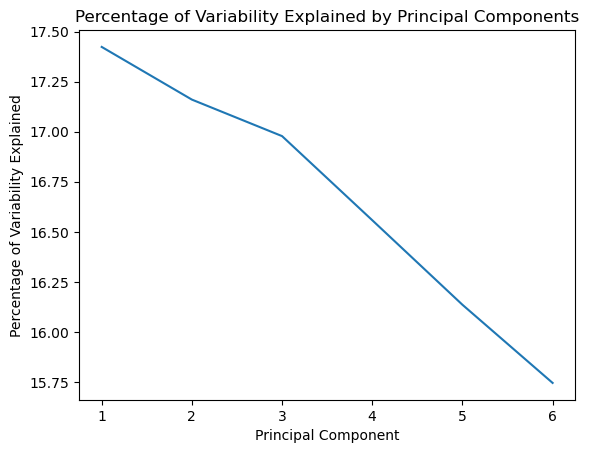

In [10]:
plt.plot(range(1, len(pc_var_explained) + 1),
         pc_var_explained * 100)
plt.xlabel("Principal Component")
plt.ylabel("Percentage of Variability Explained")
plt.title("Percentage of Variability Explained by Principal Components")
plt.show()

In [11]:
pd.DataFrame({
    "Principal Component": range(1, len(pc_var_explained) + 1),
    "Variability Explained": pc_var_explained,
    "Cumulative Variability Explained": pc_var_explained.cumsum()
})

,Principal Component,Variability Explained,Cumulative Variability Explained
0,1,0.174231,0.174231
1,2,0.171601,0.345832
2,3,0.169778,0.515609
3,4,0.165579,0.681188
4,5,0.161358,0.842546
5,6,0.157454,1.000000


As shown in both the scree plot and the table of variability explained, there is no obvious cutoff point that will significantly reduce the dimensionality of these features. We see no flattening in the scree plot and we need 5 out of the 6 principal components to explain at least 80% of the variance in these numeric features. Thus, principal component analysis will not be helpful for our project. This is not too surprising because we only have 6 numeric features, and we would hope that they all add lots of new information that can help us better predict a student's exam score based on these features.

## Clustering Techniques

First let's apply KMeans to the numeric features in our dataset with a different number of clusters for each model.

In [12]:
scaler = StandardScaler()
numerics_scaled = scaler.fit_transform(df_numeric_features)

In [13]:
kmeans_2 = KMeans(n_clusters=2)
class_predictions_2 = kmeans_2.fit_predict(numerics_scaled)

C:\Users\david\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


In [14]:
kmeans_3 = KMeans(n_clusters=3)
class_predictions_3 = kmeans_3.fit_predict(numerics_scaled)

C:\Users\david\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


In [15]:
kmeans_4 = KMeans(n_clusters=4)
class_predictions_4 = kmeans_4.fit_predict(numerics_scaled)

C:\Users\david\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


In [16]:
silhouette_score(numerics_scaled, class_predictions_2)

0.12791809145806748

In [17]:
silhouette_score(numerics_scaled, class_predictions_3)

0.1216163010966422

In [18]:
silhouette_score(numerics_scaled, class_predictions_4)

0.11938134230581296

Evaluating these three models, it seems like K means with 2 clusters achieves the best silhouette score, so we will use this to try to separate the data. Let's visualize all of the pairwise relationships between these numeric variables, coloring the data points by their cluster.

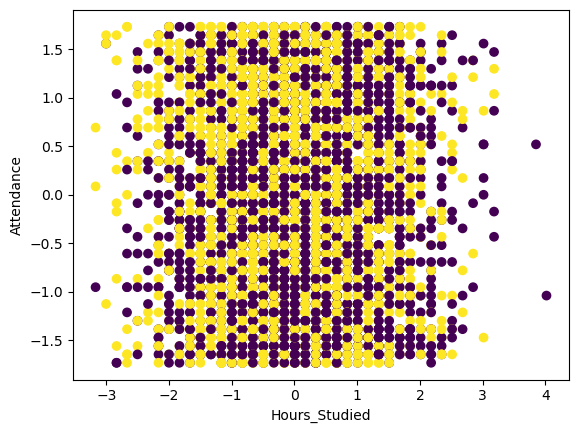

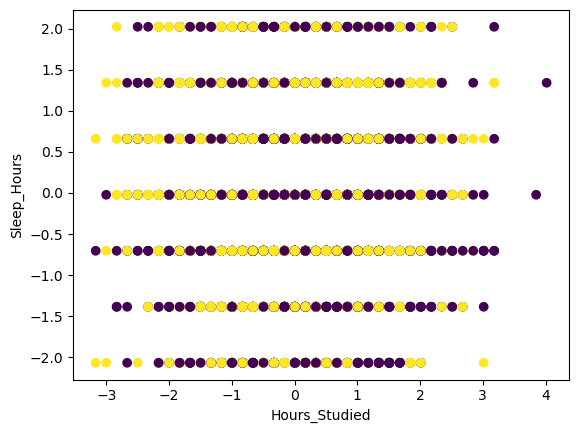

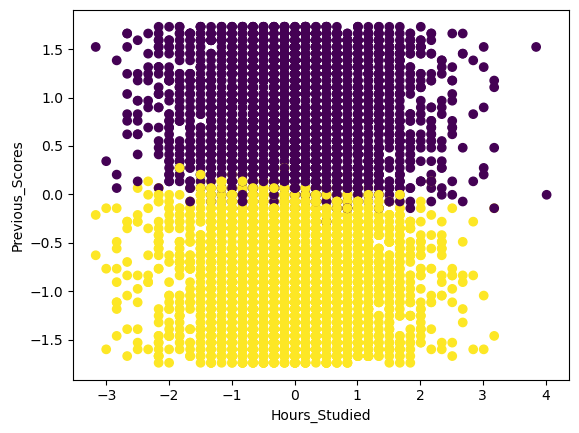

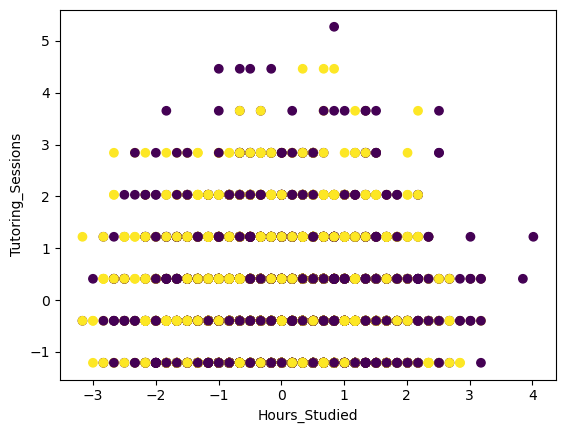

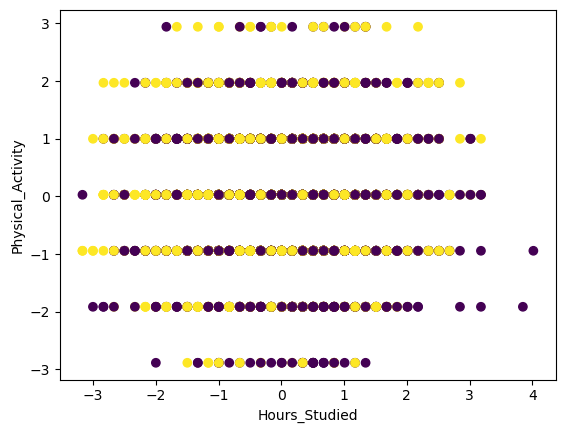

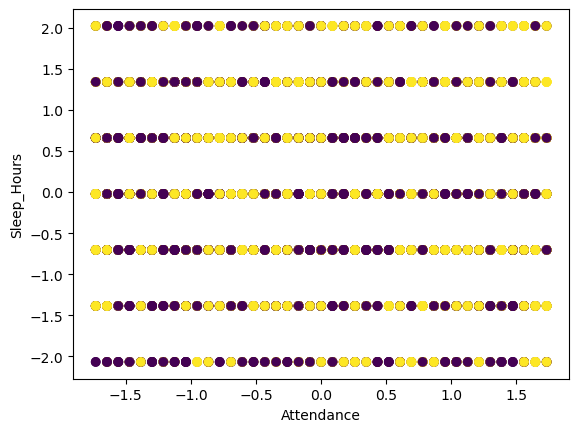

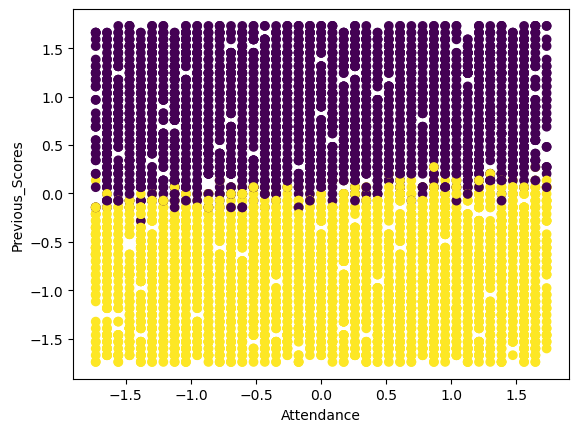

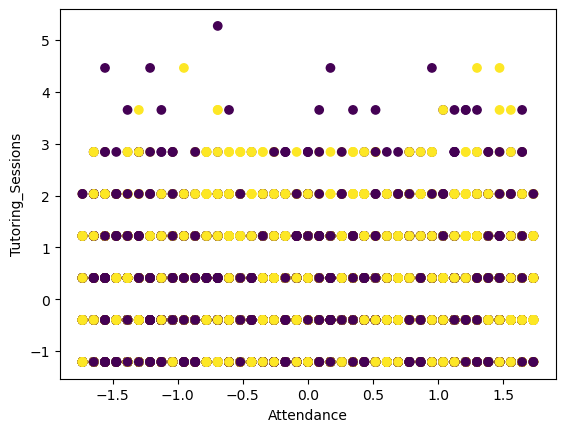

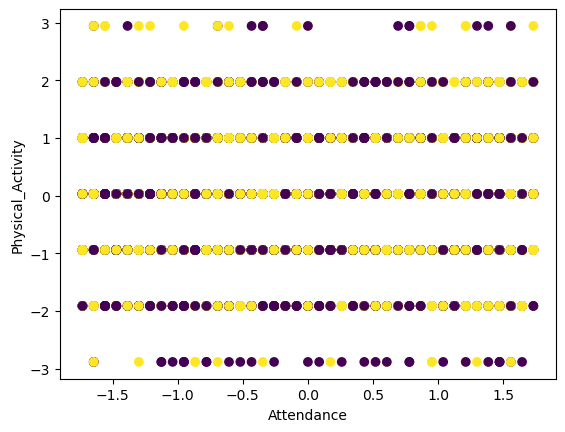

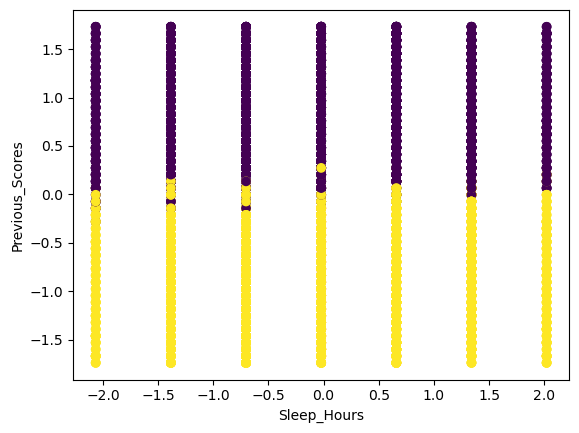

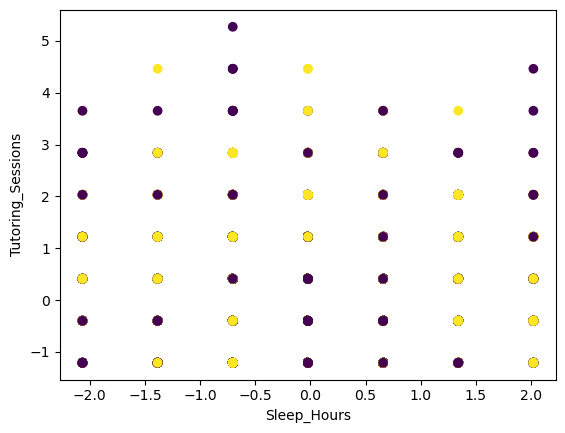

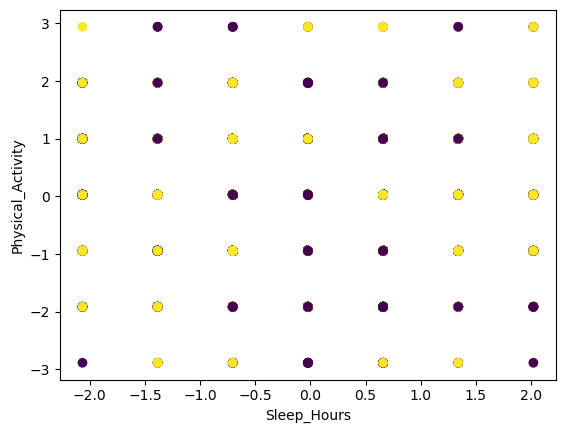

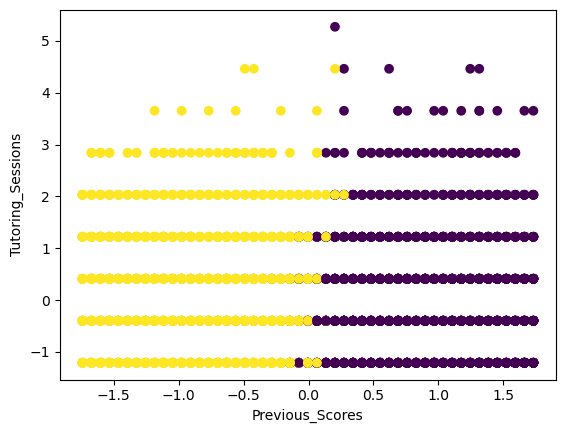

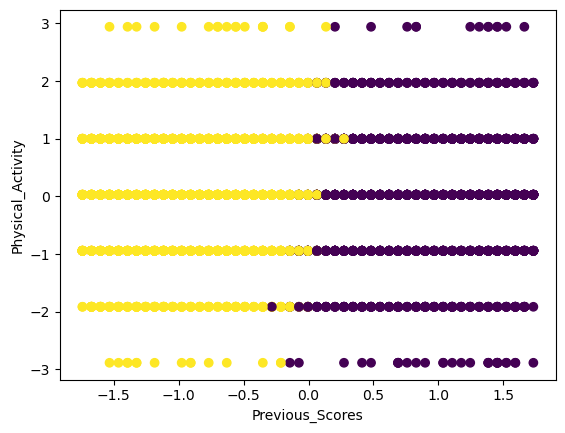

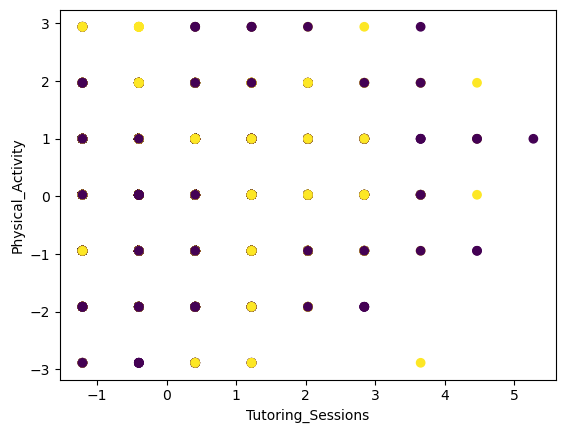

In [19]:
for i in range(numerics_scaled.shape[1]):
    for j in range(i+1, numerics_scaled.shape[1]):
        plt.scatter(numerics_scaled[:,i], numerics_scaled[:,j], c=class_predictions_2)
        plt.xlabel(df_numeric_features.columns[i])
        plt.ylabel(df_numeric_features.columns[j])
        plt.show()

As you can see in the plots above, we get very good separation of classes when visualizing previous scores vs. all other numeric features.

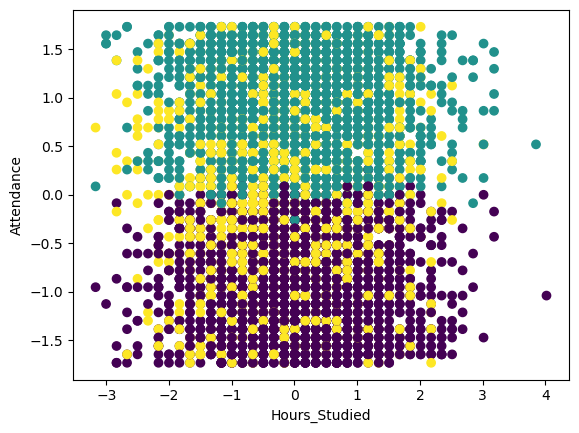

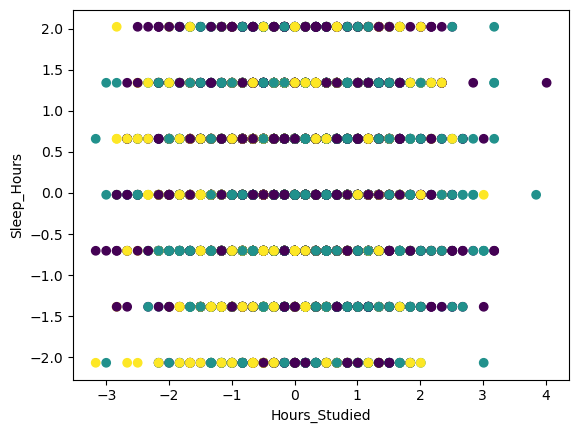

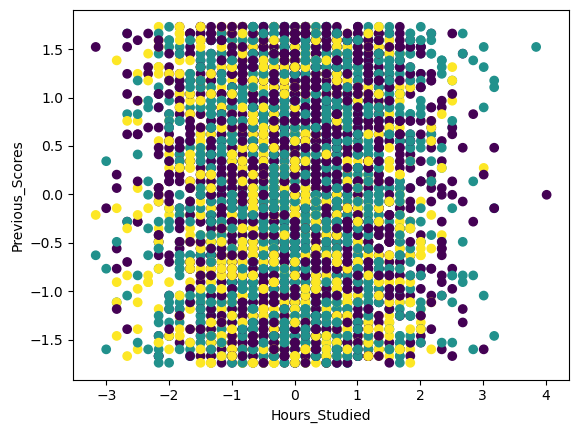

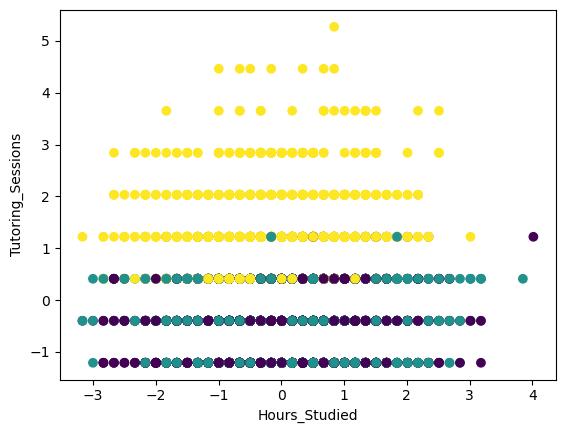

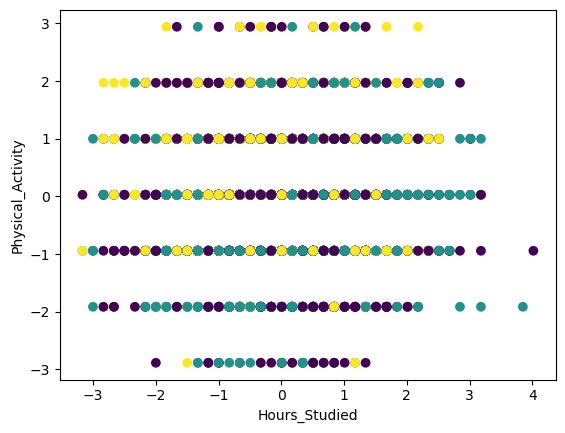

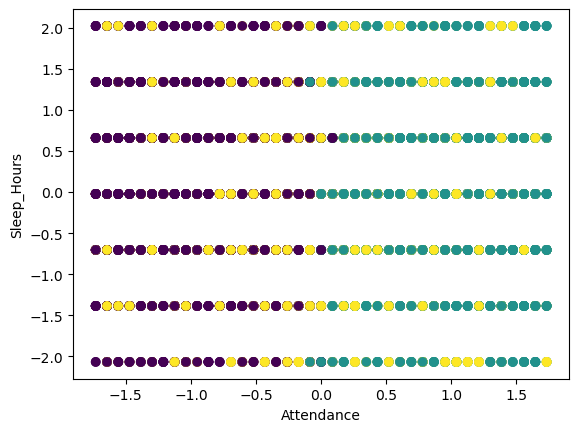

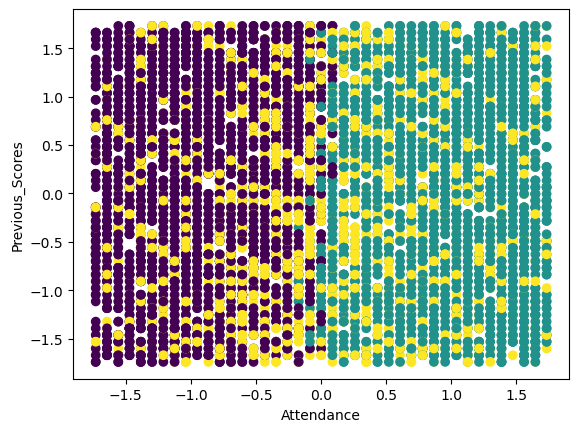

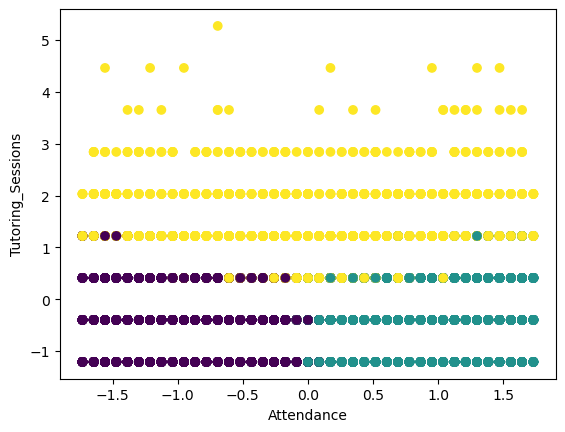

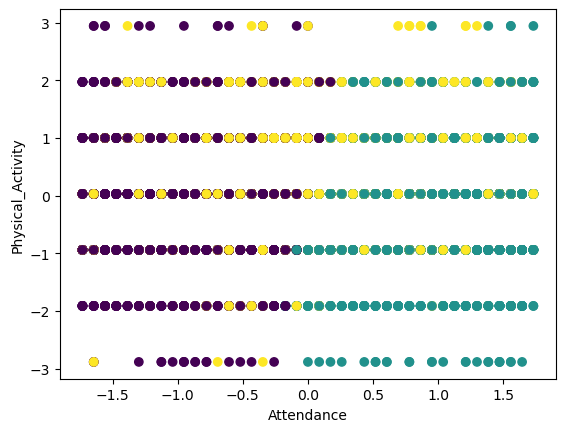

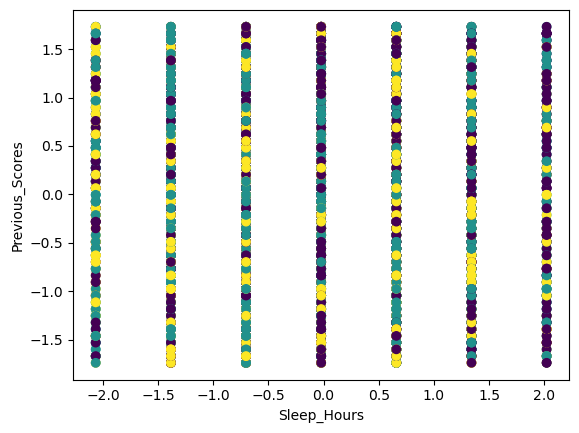

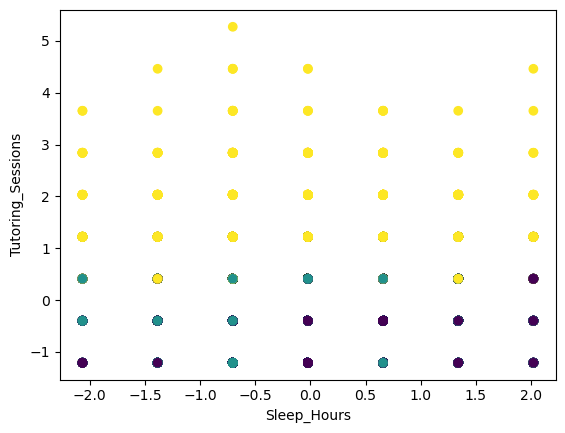

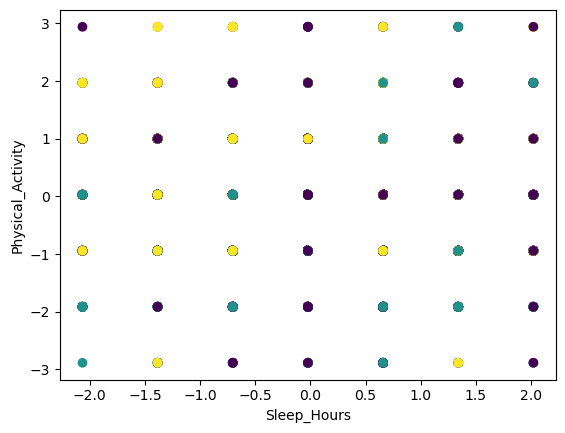

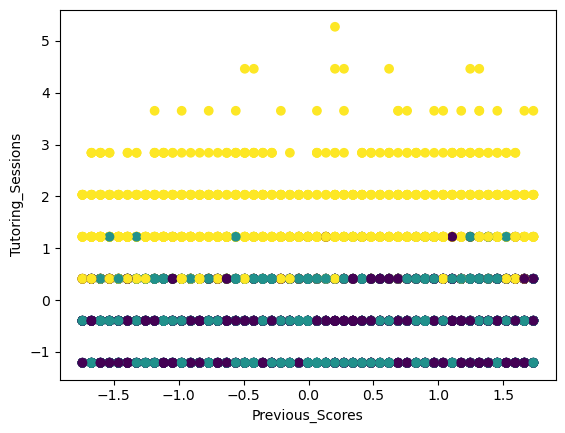

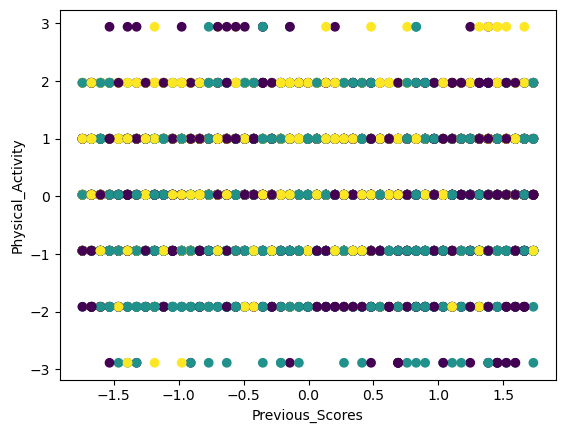

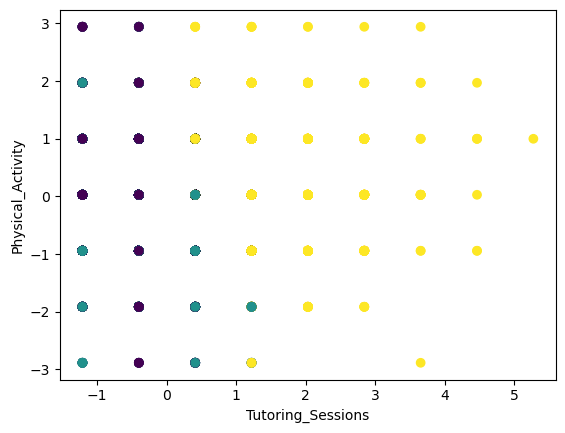

In [20]:
for i in range(numerics_scaled.shape[1]):
    for j in range(i+1, numerics_scaled.shape[1]):
        plt.scatter(numerics_scaled[:,i], numerics_scaled[:,j], c=class_predictions_3)
        plt.xlabel(df_numeric_features.columns[i])
        plt.ylabel(df_numeric_features.columns[j])
        plt.show()

If we look at the same pairwise plots for K=3, we see different kinds of separations with other variables besides the previous scores. Thus, it may actually be better to use K=3 to separate our numeric data than k=2. From this data, we could potentially describe different categories/behaviors of students. For example, the purple class above represents students who attend a lot of tutoring sessions (students who need extra support outside of class time), the yellow class represents students who have good class attendance and only attend a few tutoring sessions (students who attend class regularly and understand the course content well), and the green class represents students who have low overall class attendance and attend very few tutoring sessions (students who are either naturals and don't even need to attend class to succeed or students who don't care about the class and are simply not engaged). We may be able to use these clusters to separate our students and better understand their final exam performance.